In [1]:
%load_ext autoreload
%autoreload 2

import collections
import copy
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor
import tqdm
from typing import Any, Iterable

import block_formats.experiments as E

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

def df_select(df: pd.DataFrame, select: dict[str, Any], drop: bool = True) -> pd.DataFrame:
    d = df
    for c, value in select.items():
        if isinstance(value, list):
            d = d[d[c].isin(value)]
        else:
            d = d[d[c] == value]
            if drop:
                d = d.drop(columns=c)
    return d

def pareto_optimal(s0: pd.Series, s1: pd.Series) -> pd.Series:
    assert np.array_equal(s0.index, s1.index)
    a = np.array(s0)
    b = np.array(s1)
    optimal = (
        ~((a[None, :] < a[:, None]) & (b[None, :] <= b[:, None])).any(1)
        & ~((a[None, :] <= a[:, None]) & (b[None, :] < b[:, None])).any(1)
    )
    return pd.Series(optimal, index=s0.index)

## Baselines

In [6]:
runs = E.runs("20250504-baselines")
baselines = pd.DataFrame.from_records(dict(model=run.config.model, duration=run.meta.duration, xent=tensor(run.summary.cross_entropy).mean().item()) for run in runs)
display(baselines.sort_values("xent"))

,model,duration,xent
10,google/gemma-3-12b-pt,75.853491,1.698757
6,meta-llama/Llama-3.1-8B,25.080867,1.757471
9,microsoft/phi-4,44.099678,1.795534
7,Qwen/Qwen2.5-7B,24.572347,1.851514
8,google/gemma-3-4b-pt,101.859420,1.923320
3,meta-llama/Llama-3.2-3B,13.274956,1.973079
5,Qwen/Qwen2.5-3B,13.383883,2.008259
2,Qwen/Qwen2.5-1.5B,7.708094,2.146653
0,meta-llama/Llama-3.2-1B,5.827464,2.195862
4,google/gemma-3-1b-pt,117.434800,2.275720


## Sweep

In [9]:
runs = E.runs("20250504-sweep", progress=True)
display(collections.Counter((run.config.model, run.meta.status) for run in runs))

query: 0it [00:00, ?it/s]

query: 12096it [01:01, 195.70it/s]


Counter({('meta-llama/Llama-3.1-8B', 'finished'): 1512,
         ('microsoft/phi-4', 'finished'): 1512,
         ('Qwen/Qwen2.5-7B', 'finished'): 1512,
         ('meta-llama/Llama-3.2-3B', 'finished'): 1512,
         ('meta-llama/Llama-3.2-1B', 'finished'): 1512,
         ('Qwen/Qwen2.5-3B', 'finished'): 1512,
         ('Qwen/Qwen2.5-1.5B', 'finished'): 1512,
         ('Qwen/Qwen2.5-0.5B', 'finished'): 1512})

In [10]:
def get_element_format_name(fmt: E.AttrDict) -> str:
    name = fmt.element_family
    if name == "fp" and "exponent_bits" in fmt.args:
        name = f"{name}-E{fmt.args.exponent_bits:.0f}"
    if name == "t" and "df" in fmt.args:
        name = f"{name}[{fmt.args.df:.0f}]"
    if fmt.compressor is not None:
        name = f"{name}+Z{fmt.compressor}"
    return name

def mean_and_stderr(name: str, data: list[float]) -> dict[str, float]:
    data = tensor(data)
    return {name: data.mean().item(),
            f"{name}_stderr": data.std().item() / len(data)**.5}

def to_row(run: dict[str, Any]) -> dict[str, Any]:
    test = run.config.test
    if test.type != "baseline" and run.meta.status == "finished":
        fmt = test.fmt
        return dict(
            model=run.config.model.split("/")[1],
            element_bits=fmt.element_bits,
            element_family=fmt.element_family,
            element_name=get_element_format_name(fmt),
            element_mode=fmt.args.get("mode", None),
            scaling=fmt.scaling,
            block={(None, None): "tensor", (1, None): "channel"}.get(tuple(fmt.block_shape), fmt.block_shape[1]),
            sparse_ratio=fmt.sparse_ratio,
            compression=fmt.compressor == "optimal",
            # Outcome
            **mean_and_stderr("kl_div", run.summary.kl_div),
            **mean_and_stderr("cross_entropy", run.summary.cross_entropy),
            bits_per_param=run.summary.bits_per_param,
        )

df = pd.DataFrame.from_records(list(filter(None, map(to_row, runs))))
df["kl_div_norm"] = df.kl_div * 2**(2*df.bits_per_param)
df.head()

,model,element_bits,element_family,element_name,element_mode,scaling,block,sparse_ratio,compression,kl_div,kl_div_stderr,cross_entropy,cross_entropy_stderr,bits_per_param,kl_div_norm
0,Llama-3.1-8B,3.0,int,int+Zoptimal,None,rms,channel,0.000977,True,0.181744,0.005317,1.949379,0.029223,3.056604,12.581136
1,Llama-3.1-8B,3.0,int,int+Zoptimal,None,rms,channel,0.000000,True,0.200403,0.005500,1.968695,0.029633,3.000388,12.832672
2,Llama-3.1-8B,3.0,int,int+Zoptimal,None,rms,channel,0.007812,True,0.178216,0.005066,1.945270,0.029601,3.374730,19.175067
3,Llama-3.1-8B,3.0,int,int+Zoptimal,None,rms,64.0,0.000000,True,0.193543,0.005182,1.962224,0.029575,3.254851,17.635701
4,Llama-3.1-8B,3.0,int,int+Zoptimal,None,rms,64.0,0.007812,True,0.186345,0.005154,1.955018,0.029227,3.630242,28.572055


In [6]:
assert df.groupby(["model", "element_bits", "element_name", "element_mode", "scaling", "block", "sparse_ratio"]).apply(len, include_groups=False).max() == 1
display(df.model.unique())

array(['Llama-3.1-8B', 'phi-4', 'Qwen2.5-7B', 'Llama-3.2-3B',
       'Llama-3.2-1B', 'Qwen2.5-3B', 'Qwen2.5-1.5B', 'Qwen2.5-0.5B'],
      dtype=object)

In [11]:
def add_error_ratio_indicator(error_ratio: float, ax: matplotlib.axes.Axes, pos: float = 0.97) -> None:
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    ox = x1 ** pos * x0 ** (1-pos)
    oy = y1 ** pos * y0 ** (1-pos)
    ax.errorbar(ox, oy, oy * error_ratio, fmt="_", capsize=3.5, ms=4, lw=0.5, mew=0.5, color="k")
    ax.annotate(r"stderr", (ox, oy), ha="right", va="center",
                fontsize=8, fontstyle="italic", xytext=(-5, 0), textcoords="offset points")

### Simplified Pareto

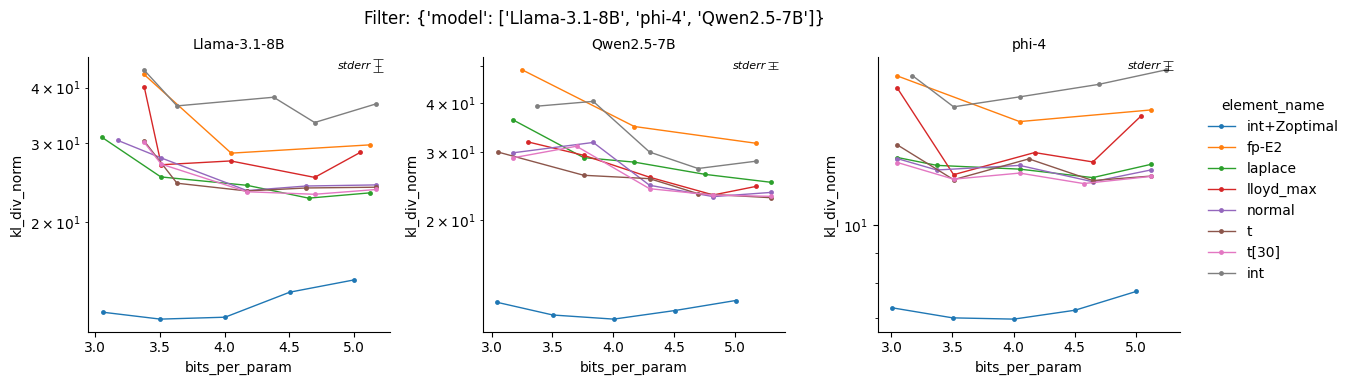

In [31]:
def show_pareto_simple(select: dict[str, Any], hue: str, hue_norm: matplotlib.colors.Normalize | None = None, col: str = "model") -> None:
    d = (df_select(df, select, drop=False)
        .groupby([col, hue, "element_bits"])
        .apply(lambda d: d.loc[d.kl_div_norm.idxmin()], include_groups=False)
        .sort_values("bits_per_param", kind="stable")
        .reset_index()
        )

    cols = sorted(d[col].unique())
    hue_order = d[hue].unique() if hue_norm is None else None
    size = 4
    fig, axs = plt.subplots(ncols=len(cols), figsize=(size*len(cols), size), sharey=False, squeeze=False)
    for col_value, ax in zip(cols, axs[0]):
        g = d[d[col] == col_value]
        ax = sns.lineplot(data=g, y="kl_div_norm", x="bits_per_param",
                          hue=hue, hue_norm=hue_norm, hue_order=hue_order, palette="flare" if d[hue].dtype.kind == "f" else None,
                          marker=".", ms=7, mew=0, lw=1, ax=ax)
        ax.set_yscale("log")
        ax.set_title(col_value, fontsize=10)
        add_error_ratio_indicator((g.kl_div_stderr / g.kl_div).mean(), ax)
        ax.legend_.remove()
    fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5), title=hue)
    fig.suptitle(f"Filter: {str(select)}", y=0.95)
    fig.tight_layout()

show_pareto_simple(dict(model=["Llama-3.1-8B", "phi-4", "Qwen2.5-7B"]), hue="element_name")

### Full Pareto

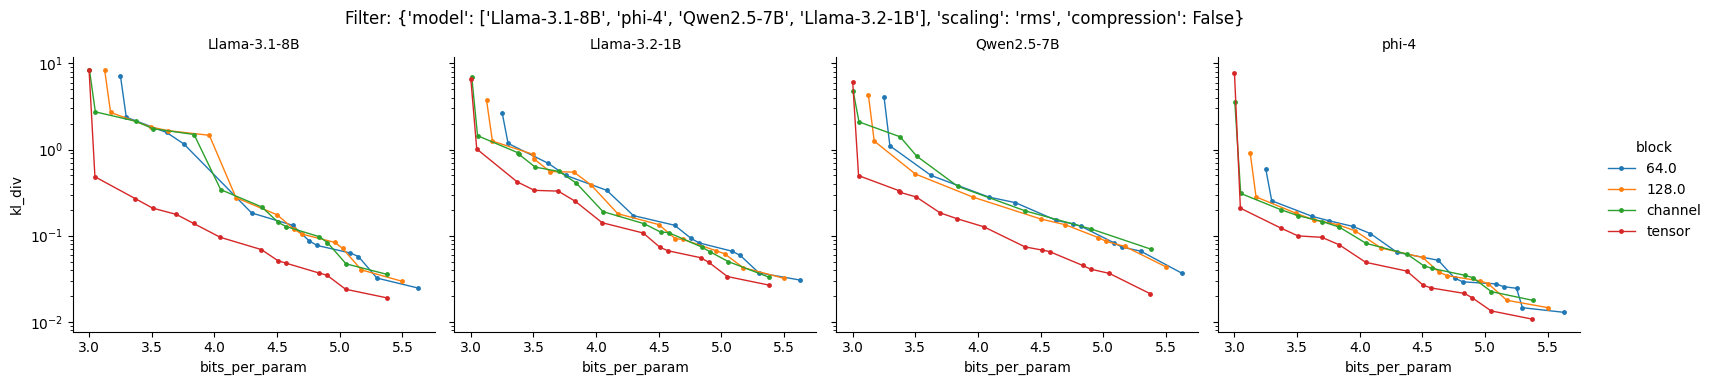

In [ ]:
def show_pareto(select: dict[str, Any], hue: str, hue_norm: matplotlib.colors.Normalize | None = None, col: str = "model") -> None:
    d = (df_select(df, select, drop=False)
        .groupby([col, hue])
        .apply(lambda d: d[pareto_optimal(d.kl_div, d.bits_per_param)].sort_values("bits_per_param"), include_groups=False)
        .reset_index()
        )

    cols = sorted(d[col].unique())
    hue_order = d[hue].unique() if hue_norm is None else None
    size = 4
    fig, axs = plt.subplots(ncols=len(cols), figsize=(size*len(cols), size), sharey=True, squeeze=False)
    for col_value, ax in zip(cols, axs[0]):
        g = d[d[col] == col_value]
        ax = sns.lineplot(data=g, y="kl_div", x="bits_per_param",
                          hue=hue, hue_norm=hue_norm, hue_order=hue_order, palette="flare" if d[hue].dtype.kind == "f" else None,
                          marker=".", ms=7, mew=0, lw=1, ax=ax)
        ax.set_yscale("log")
        ax.set_title(col_value, fontsize=10)
        # ax.set_ylim((g.kl_div_norm.min() * 0.9, 210))
        # add_error_ratio_indicator((g.kl_div_stderr / g.kl_div).mean(), ax)

        ax.legend_.remove()
    fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5), title=hue)
    fig.suptitle(f"Filter: {str(select)}", y=0.95)
    fig.tight_layout()

# show_pareto(dict(model=["Llama-3.1-8B", "phi-4", "Qwen2.5-7B"]), hue="compression")
# RMS requires sparse outliers
# show_pareto(dict(model=["Llama-3.1-8B", "phi-4", "Qwen2.5-7B"], scaling="rms", compression=False),
#             hue="sparse_ratio", hue_norm=matplotlib.colors.SymLogNorm(2**-10))
# ...but doesn't require block scaling
show_pareto(dict(model=["Llama-3.1-8B", "phi-4", "Qwen2.5-7B"], scaling="rms", compression=False),
            hue="block")
# Absmax doesn't require sparse outliers
# show_pareto(dict(model=["Llama-3.1-8B", "phi-4", "Qwen2.5-7B"], scaling="absmax", compression=False),
#             hue="sparse_ratio", hue_norm=matplotlib.colors.SymLogNorm(2**-10))
# ...but does require block scaling
# show_pareto(dict(model=["Llama-3.1-8B", "phi-4", "Qwen2.5-7B"], scaling="absmax", compression=False, sparse_ratio=0),
#             hue="block")

In [353]:
dfb = (df.groupby(["model", "element_bits", "compression"])
 .apply(lambda d: d.loc[d.kl_div_norm.idxmin()], include_groups=False)
 .reset_index()
)
dfb[(dfb.model == "Llama-3.1-8B") & (~dfb.compression)]

,model,element_bits,compression,element_family,element_name,element_mode,scaling,block,sparse_ratio,kl_div,kl_div_stderr,cross_entropy,cross_entropy_stderr,bits_per_param,kl_div_norm
0,Llama-3.1-8B,3.0,False,t,t[30],asymmetric,absmax,tensor,0.007812,0.280879,0.006543,2.050731,0.029324,3.375419,30.249958
2,Llama-3.1-8B,3.5,False,t,t,symmetric,absmax,128.0,0.000977,0.159106,0.004787,1.925103,0.029576,3.631717,24.445469
4,Llama-3.1-8B,4.0,False,t,t[30],asymmetric,absmax,128.0,0.000977,0.071973,0.002660,1.831624,0.029407,4.172267,23.395045
6,Llama-3.1-8B,4.5,False,laplace,laplace,symmetric,absmax,128.0,0.000000,0.035965,0.001460,1.791976,0.029529,4.648938,22.637061
8,Llama-3.1-8B,5.0,False,laplace,laplace,asymmetric,absmax,128.0,0.000000,0.019094,0.000863,1.776587,0.029580,5.125361,23.263607


505


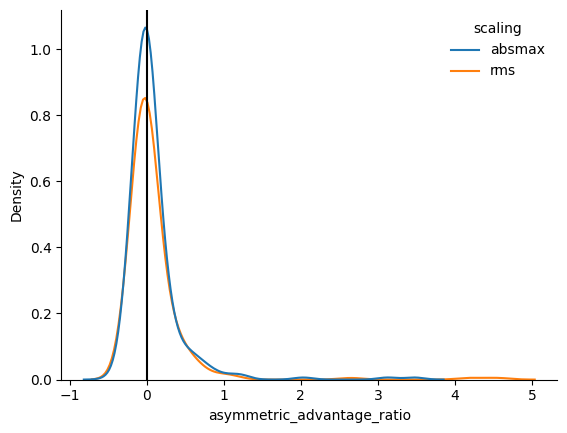

In [94]:
d = (df
    .pipe(lambda d: d[~d.compression & d.element_family.isin(["int", "normal", "laplace", "t"])])
    .pipe(lambda d: d[d.model == "phi-4"])
    # .pipe(lambda d: d[d.kl_div < 1])
    .pipe(lambda d: d[d.kl_div_norm < 10])
    .groupby(["model", "element_bits", "element_name", "scaling", "block", "sparse_ratio"])
    .apply(lambda d: pd.Series(dict(
        kl_symmetric=d.kl_div[d.element_mode == "symmetric"].iloc[0],
        kl_asymmetric=d.kl_div[d.element_mode == "asymmetric"].iloc[0],
        asymmetric_advantage=d.kl_div[d.element_mode == "symmetric"].iloc[0] - d.kl_div[d.element_mode == "asymmetric"].iloc[0]
    )) if len(d) == 2 else None, include_groups=False)
    .reset_index()
    .pipe(lambda d: d[~d.asymmetric_advantage.isna()])
)
print(len(d))
d["asymmetric_advantage_ratio"] = d["asymmetric_advantage"] / d["kl_asymmetric"]
ax = sns.kdeplot(d, x="asymmetric_advantage_ratio", hue="scaling")
ax.axvline(0, color="k")
# d.sort_values("asymmetric_advantage")
# d[d.asymmetric_advantage_ratio < -0.1].sort_values("kl_symmetric")

In [21]:
best_mode = (df.groupby(["model", "element_bits", "element_name", "scaling", "block", "sparse_ratio"])
 .apply(lambda d: d.loc[d.kl_div.idxmin()], include_groups=False)
 .reset_index()
)

In [31]:
(best_mode.pipe(lambda d: d[d.model == "Llama-3.1-8B"])
 .groupby(["scaling", "element_name"]).apply(lambda d: d.element_mode.value_counts(), include_groups=False))

scaling  element_name  element_mode
absmax   int           asymmetric      35
                       symmetric       25
         laplace       symmetric       31
                       asymmetric      29
         normal        asymmetric      35
                       symmetric       25
         t             asymmetric      38
                       symmetric       22
         t[30]         asymmetric      37
                       symmetric       23
rms      int           symmetric       46
                       asymmetric      14
         laplace       symmetric       42
                       asymmetric      18
         normal        symmetric       42
                       asymmetric      18
         t             symmetric       45
                       asymmetric      15
         t[30]         symmetric       43
                       asymmetric      17
Name: count, dtype: int64

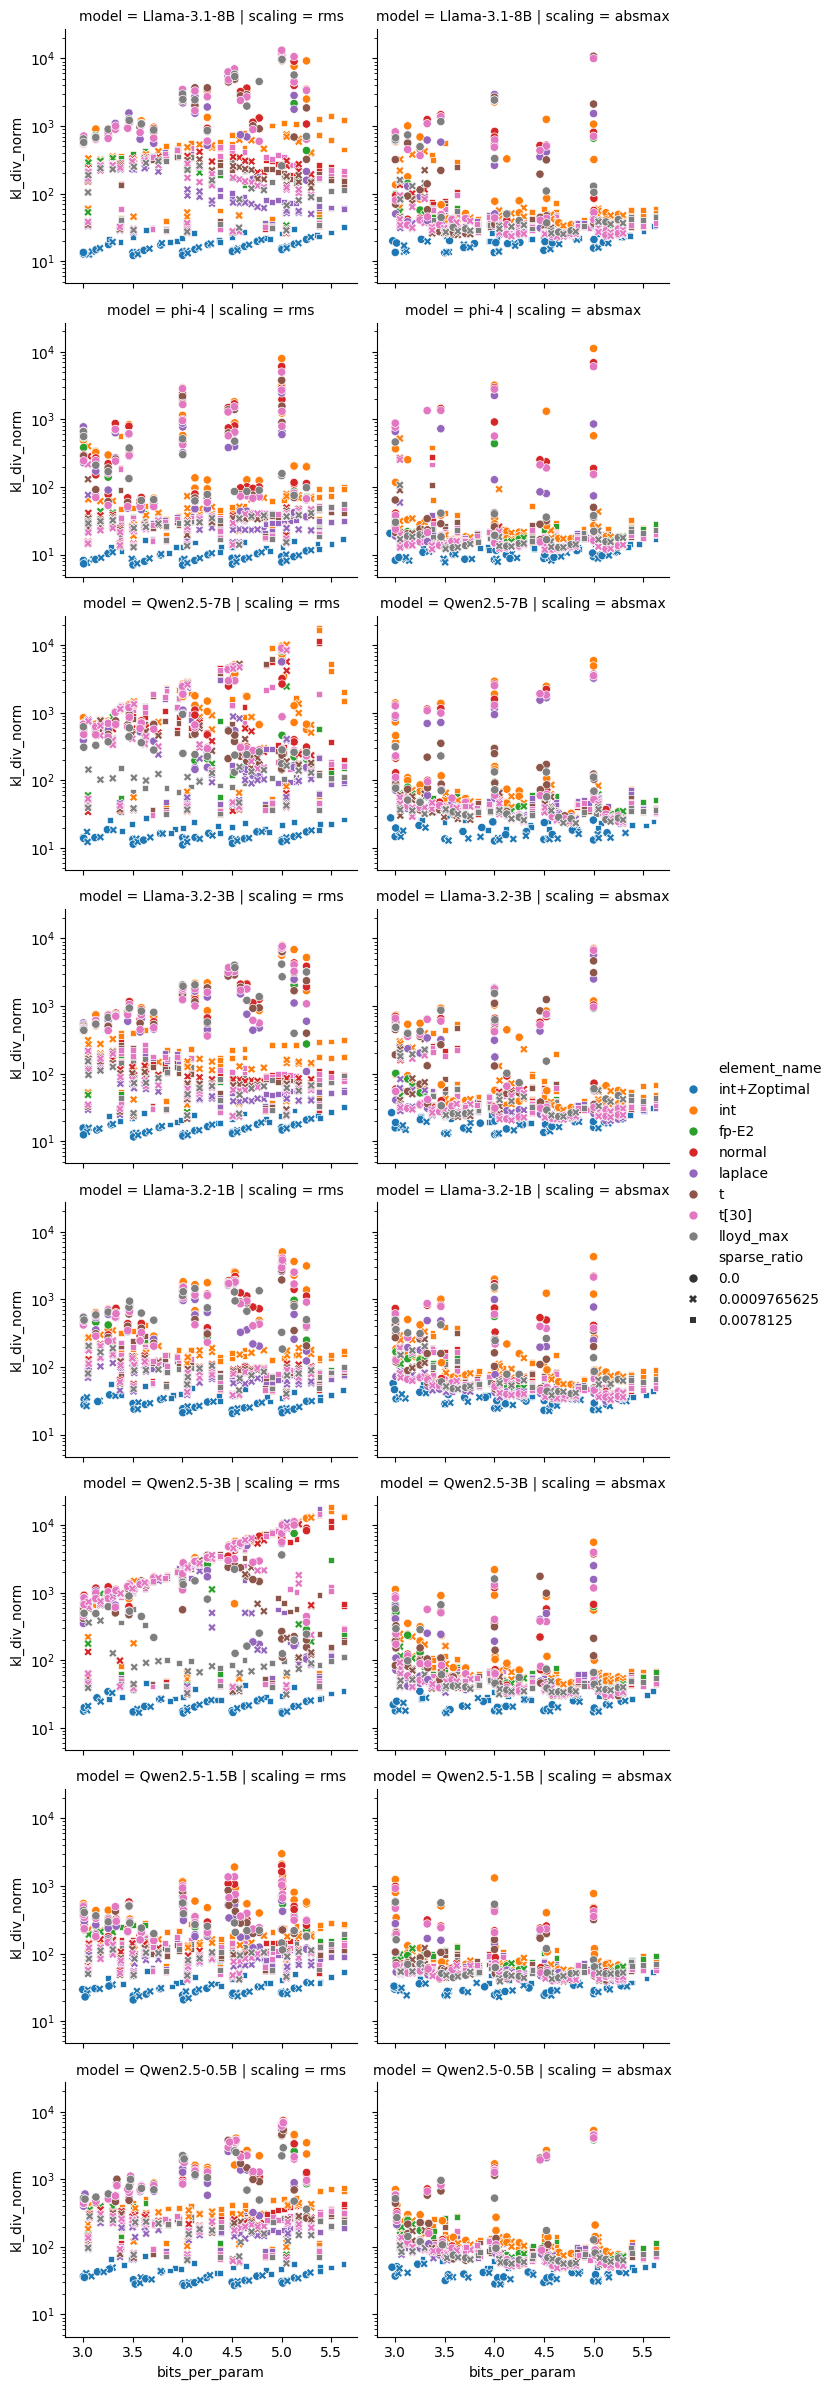

In [171]:
df["kl_div_norm"] = df.kl_div * 2**(2*df.bits_per_param)
g = sns.relplot(data=df, y="kl_div_norm", x="bits_per_param", col="scaling", row="model", hue="element_name", style="sparse_ratio",
                height=3, aspect=1.2)
for ax in g.axes.flatten():
    ax.set_yscale("log")
    # ax.set_ylim((0.01, 1))
    # ax.set_ylim((0.2, 20))